In [126]:
#s0 libs

using DelimitedFiles
using Plots
using StatsBase
using Test

#=
intent
take an array of durations of seclusion
count the actua distribution of durations
see this curve as being a probability mass function based on four other curves
over        an even Poisson
under       an odd Poisson
between     a recurring paraboloid curve which handles the gap between them
     - rescale the gap as a series of trapezoids
     - area of a parabold inside a trapezoid is 2/3 the trapezoid and width is fixed
leftover    an error function with its own polynomial mechanics


=#

#s1 config

function get_limit()
    limit   = 2
    return limit
end

function get_xs()
    ticks   = 10
    xs      = [float(x) for x in collect(1:ticks)]
    return xs
end

function get_width_of_hists()
    width_of_hists = 1
    return width_of_hists
end

#s2 model

function get_limited()
    durations           = get_durations()
    total               = length(durations)
    limit               = get_limit()
    limited             = [d for d in durations if d<=limit]
    cumulative_fraction = length(limited)/total
    println("only looking at first:\t\t\t",limit," days")
    println("proportion out by then is about:\t", trunc(Int64,cumulative_fraction*100),"%")
    return limited
end

function operate_on(xs::Array{Float64,1})
    ys = [maximum(xs)-x^2 for x in xs]
    return ys
end

#s3 in out

function draw_cont_scat_freqs(limited)
    count_durs      = collect(countmap(limited))
    durs            = [x[1] for x in count_durs]
    freqs           = [x[2] for x in count_durs]
    cont_scat_freqs = scatter(durs, freqs, alpha=0.25, title="durations", legend=false)
    return cont_scat_freqs
end

function draw_hist_freqs(limited)
    limit           = get_limit()
    minutes         = limit*24*60
    width_of_hists  = get_width_of_hists()
    n_hists::Int    = minutes/width_of_hists
    println("In the bar chart each bar covers:\t", width_of_hists, " minute(s)")
    println("...so there are:\t\t\t", n_hists, " slices in that graph")
    hist_freqs      = histogram(limited, bins=n_hists, alpha=0.5, legend=false, title="durations")
    return hist_freqs
end

function draw_scat_abs(limited)
    orders          = 1:length(limited)
    scat_abs        = scatter(orders, limited, alpha=0.02, title="ordered length", legend=false)
    return scat_abs
end

function draw_scat_logs(limited)
    orders          = 1:length(limited)
    log_abs         = [log2(d) for d in limited]
    scat_logs       = scatter(orders, log_abs, alpha=0.1, title="log length by order", legend=false)
    return scat_logs
end

function get_durations()
    output_matrix = readdlm("durations.txt", ' ', Float64, '\n')
    durations     = output_matrix[1,:]
    return durations
end



get_durations (generic function with 1 method)

In [127]:
function no_real_analysis()
    limited         = get_limited()
    cont_scat_freqs = draw_cont_scat_freqs(limited)
    hist_freqs      = draw_hist_freqs(limited)
    unanalysed      = plot(cont_scat_freqs, hist_freqs, layout=(1,2), legend=false)
    return unanalysed
end

function initial_analysis()
    limited         = get_limited()
    scat_logs       = draw_scat_logs(limited)
    scat_abs        = draw_scat_abs(limited)
    initial         = plot(scat_abs, scat_logs, layout=(1,2), legend=false)
    return initial
end

function harry_main()
    unanalysed      = no_real_analysis()
    initial         = initial_analysis()              
    return unanalysed, initial
end

unanalysed, initial = harry_main();
    

only looking at first:			2 days
proportion out by then is about:	82%
In the bar chart each bar covers:	1 minute(s)
...so there are:			2880 slices in that graph
only looking at first:			2 days
proportion out by then is about:	82%


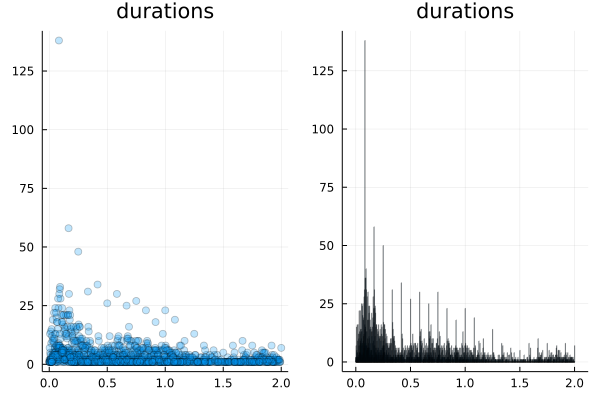

In [128]:
unanalysed

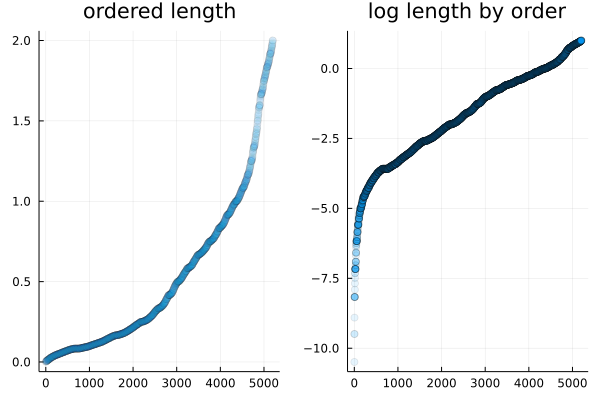

In [129]:
initial

In [130]:
#s7 tests

function test_operate_on()
    xs = get_xs()
    ys = operate_on(xs)
    @test typeof(ys) == Array{Float64,1}
    println("passed type testing for operate on")
end

function harry_tests()
    test_operate_on()
end

harry_tests()

passed type testing for operate on
